## Kaggle Titanic

### Feat7/wip (Acc: on test set 0.8256)
#### Slightly worse than feat2

Branced from feat7 with XGboost to start training model with SVM
- Scaling numerical feature with 0-1 range, scaling with training set range after splitting train-test set
- Assign age to NaN values based on initials
- Assign S to NaN values
- Dropped Cabin, name, ticket and passengerID

In [2]:
%%bash
git log

commit e8eed44a39da56f6ccb186d2e9ec8f96a99a552c
Author: Theerit <Theerit.L@gmail.com>
Date:   Wed Apr 11 15:36:26 2018 +0700

    Fixing scaling code

commit ef1f4faabe516a9eebd95a5a8a18307caa945159
Author: Theerit <Theerit.L@gmail.com>
Date:   Wed Apr 11 15:26:59 2018 +0700

    Modified scaling and training code

commit d66a2ac6c59a678da4565864f51882d60fb0beaa
Author: Theerit <Theerit.L@gmail.com>
Date:   Wed Apr 11 15:03:21 2018 +0700

    new SVM branched

commit a405168c6cc7ea41bd26d9e0cf92e23faf7ffb8f
Author: Theerit <Theerit.L@gmail.com>
Date:   Thu Mar 22 17:26:23 2018 +0700

    Submitted to Kaggle, Dummy Commit to change branch

commit d4d320a972db84a3ee4c122ed040cb706f410266
Author: Theerit <Theerit.L@gmail.com>
Date:   Mon Mar 19 18:49:37 2018 +0700

    Created submission File

commit d1190156dd9a7da790091ab74743b33c998a1408
Author: Theerit <Theerit.L@gmail.com>
Date:   Mon Mar 19 18:46:22 2018 +0700

    Modified head markdown

commit 11d36d8643e7fa2299a91e013a38b81249d8b

In [8]:
%%bash
git add 'Titanic.ipynb'
git add 'Test_data.ipynb'
git commit -m 'Updated Scaling Code'
git push --set-upstream origin 'feat7(EDA1)/SVM/wip'

[feat7(EDA1)/SVM/wip ef1f4fa] Modified scaling and training code
 1 file changed, 69 insertions(+), 39 deletions(-)
Branch feat7(EDA1)/SVM/wip set up to track remote branch feat7(EDA1)/SVM/wip from origin.


To github.com:Theerit/Kaggle_Titanic.git
   d66a2ac..ef1f4fa  feat7(EDA1)/SVM/wip -> feat7(EDA1)/SVM/wip


In [9]:
filename= 'feat7_svm.sav'

As usual, import all neccasary stuff into the notebook

In [3]:
%matplotlib inline 
import requests 
import StringIO
import zipfile
import numpy as np
import pandas as pd # pandas
import matplotlib.pyplot as plt # module for plotting 

# If this module is not already installed, you may need to install it. 
# You can do this by typing 'pip install seaborn' in the command line
import seaborn as sns 

import sklearn.model_selection

/Users/theerit/anaconda/envs/ipykernel_py2/lib/python2.7/site-packages/IPython/html.py:14: ShimWarning: The `IPython.html` package has been deprecated. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  "`IPython.html.widgets` has moved to `ipywidgets`.", ShimWarning)


### Feature Engineering (based on EDA1 branch)

First, I will start by loading the data in panda dataframe and do some EDA.

In [23]:
train = pd.read_csv('Train.csv')
test = pd.read_csv('Test.csv')
#Concate train and test to avoid mismatch features in the testing phase
#train_objs_num = len(train)
#dataset = pd.concat(objs=[train, test], axis=0)
#dataset = pd.get_dummies(dataset)
#train = dataset.copy(dataset[:train_objs_num])
#train = dataset[:train_objs_num].copy()
#test = dataset.copy(dataset[train_objs_num:])
#test = dataset[train_objs_num:].copy()
print(train.shape)

(891, 12)


Take a peek look at raw data table.

In [24]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


It appears that the test data has no label(answer class) and seems to serve submission function. Cross validation and model evaluation will be done based on the data provided in Train.csv file only. Next, split dataframe into X and Y dataframe where X store the data while Y store the label.

In [25]:
X = train.copy()
y = X['Survived']
X = X.drop('Survived',axis=1)
X_plot = train.copy()
X = X.drop('PassengerId',axis=1)  # Shouldn't relate to survival chance
X = X.drop('Cabin',axis=1)
X = X.drop('Ticket',axis=1)

#Mirror action on X to test
#test = test.drop('PassengerID',axis=1)
test = test.drop('PassengerId',axis=1)
test = test.drop('Cabin',axis=1)
test = test.drop('Ticket',axis=1)

#X = X.drop('Name',axis=1)
#Y = pd.DataFrame(train['Survived'])

In [26]:
Y[Y['Survived']==1].count()

NameError: name 'Y' is not defined

### Extract age from name

Extract some useful information from name, to convert the information to age. Take a look at mean age then assign person who doesn't have age (Nan value in Age) the mean value according to their initials

In [27]:
X_plot['Initial']=0
for i in X_plot:
    X_plot['Initial']=X_plot.Name.str.extract('([A-Za-z]+)\.') #lets extract the Salutations
#X_plot['Initial'].value_counts()

#Change data in X also (since its the real training data)
X['Initial']=0
for i in X:
    X['Initial']=X.Name.str.extract('([A-Za-z]+)\.') #lets extract the Salutations
#Also perform same actions on test dataframe
test['Initial']=0
for i in X:
    test['Initial']=test.Name.str.extract('([A-Za-z]+)\.') #lets extract the Salutations

pd.crosstab(X_plot.Initial,X_plot.Sex).T.style.background_gradient(cmap='summer_r')

/Users/theerit/anaconda/envs/ipykernel_py2/lib/python2.7/site-packages/ipykernel/__main__.py:3: FutureWarning: currently extract(expand=None) means expand=False (return Index/Series/DataFrame) but in a future version of pandas this will be changed to expand=True (return DataFrame)
  app.launch_new_instance()
/Users/theerit/anaconda/envs/ipykernel_py2/lib/python2.7/site-packages/ipykernel/__main__.py:9: FutureWarning: currently extract(expand=None) means expand=False (return Index/Series/DataFrame) but in a future version of pandas this will be changed to expand=True (return DataFrame)
/Users/theerit/anaconda/envs/ipykernel_py2/lib/python2.7/site-packages/ipykernel/__main__.py:13: FutureWarning: currently extract(expand=None) means expand=False (return Index/Series/DataFrame) but in a future version of pandas this will be changed to expand=True (return DataFrame)


Replace some of the initials with appropriate initials (for more accurate age assign)

In [28]:
X['Initial'].replace(['Mlle','Mme','Ms','Dr','Major','Lady','Countess','Jonkheer','Col','Rev','Capt','Sir','Don'],
                        ['Miss','Miss','Miss','Mr','Mr','Mrs','Mrs','Other','Other','Other','Mr','Mr','Mr'],inplace=True)
test['Initial'].replace(['Mlle','Mme','Ms','Dr','Major','Lady','Countess','Jonkheer','Col','Rev','Capt','Sir','Don'],
                        ['Miss','Miss','Miss','Mr','Mr','Mrs','Mrs','Other','Other','Other','Mr','Mr','Mr'],inplace=True)

In [29]:
# Take a lot at mean age of Mr vs Miss Master
print('Mean age of Mr:',X_plot[X_plot['Initial']=="Mr"]['Age'].mean())
print('Mean age of Miss:',X_plot[X_plot['Initial']=="Miss"]['Age'].mean())
print('Mean age of Mrs:',X_plot[X_plot['Initial']=="Mrs"]['Age'].mean())
print('Mean age of Master:',X_plot[X_plot['Initial']=="Master"]['Age'].mean())
others = ['Mr','Miss','Mrs','Master']
print('Mean age of others:',X_plot[~X_plot['Initial'].isin(others)]['Age'].mean())

('Mean age of Mr:', 32.368090452261306)
('Mean age of Miss:', 21.773972602739725)
('Mean age of Mrs:', 35.898148148148145)
('Mean age of Master:', 4.5741666666666667)
('Mean age of others:', 42.384615384615387)


In [30]:
X['Age'][(X['Initial']=='Mr') & (X['Age'].isnull())] = X[X['Initial']=='Mr']['Age'].mean()
X['Age'][(X['Initial']=='Miss') & (X['Age'].isnull())] = X[X['Initial']=='Miss']['Age'].mean()
X['Age'][(X['Initial']=='Mrs') & (X['Age'].isnull())] = X[X['Initial']=='Mrs']['Age'].mean()
X['Age'][(X['Initial']=='Master') & (X['Age'].isnull())] = X[X['Initial']=='Master']['Age'].mean()
X['Age'][(X['Initial']=='other') & (X['Age'].isnull())] = X[X['Initial']=='other']['Age'].mean()

test['Age'][(test['Initial']=='Mr') & (test['Age'].isnull())] = test[test['Initial']=='Mr']['Age'].mean()
test['Age'][(test['Initial']=='Miss') & (test['Age'].isnull())] = test[test['Initial']=='Miss']['Age'].mean()
test['Age'][(test['Initial']=='Mrs') & (test['Age'].isnull())] = test[test['Initial']=='Mrs']['Age'].mean()
test['Age'][(test['Initial']=='Master') & (test['Age'].isnull())] = test[test['Initial']=='Master']['Age'].mean()
test['Age'][(test['Initial']=='other') & (test['Age'].isnull())] = test[test['Initial']=='other']['Age'].mean()

/Users/theerit/anaconda/envs/ipykernel_py2/lib/python2.7/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':
/Users/theerit/anaconda/envs/ipykernel_py2/lib/python2.7/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app
/Users/theerit/anaconda/envs/ipykernel_py2/lib/python2.7/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [31]:
print(X['Age'].isnull().any())
print(test['Age'].isnull().any())

False
False


Assign "S" to Nan values

In [32]:
X['Embarked'].fillna("S",inplace=True)
X['Embarked'].isnull().any()

test['Embarked'].fillna("S",inplace=True)
test['Embarked'].isnull().any()

False

Now initial and name should be redundant features, dropping them out

In [33]:
X = X.drop('Name',axis=1)
X = X.drop('Initial',axis=1)

test = test.drop('Name',axis=1)
test = test.drop('Initial',axis =1)

In [39]:
X.head()

,Age,SibSp,Parch,Fare,Pclass_1,Pclass_2,Pclass_3,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S
0,0.271174,0.125,0.0,0.014151,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0
1,0.472229,0.125,0.0,0.139136,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
2,0.321438,0.000,0.0,0.015469,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0
3,0.434531,0.125,0.0,0.103644,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
4,0.434531,0.000,0.0,0.015713,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0


### Dummy Variables
For starter, create dummy variables for categorical features.

In [36]:
num_attri = ['Age','SibSp','Parch','Fare']
cat_attri = [column for column in X if (column not in num_attri and column != 'Survived')]

In [37]:
for column in (cat_attri):
    #Lets just keep every categorical attributes for plotting
    tempDF = pd.get_dummies(X[column],prefix=column)
    X.drop(column,axis=1,inplace=True)
    X = X.join(tempDF)
for column in (cat_attri): #Create dummy for test
    #Lets just keep every categorical attributes for plotting
    tempDF = pd.get_dummies(test[column],prefix=column)
    test.drop(column,axis=1,inplace=True)
    test = test.join(tempDF)

#Concat X(train data) with X from test data to avoid mismatch feature
train_objs_num = len(X)
dataset = pd.concat(objs=[X, test], axis=0)
#dataset = pd.get_dummies(dataset)
X = dataset[:train_objs_num].copy()
test = dataset[train_objs_num:].copy()

### Feature Evaluation

In [64]:
#Format dataframe for scikit training

In [65]:
X.isnull().any()

Age           False
SibSp         False
Parch         False
Fare          False
Pclass_1      False
Pclass_2      False
Pclass_3      False
Sex_female    False
Sex_male      False
Embarked_C    False
Embarked_Q    False
Embarked_S    False
dtype: bool

Start with numerical feature ranking first

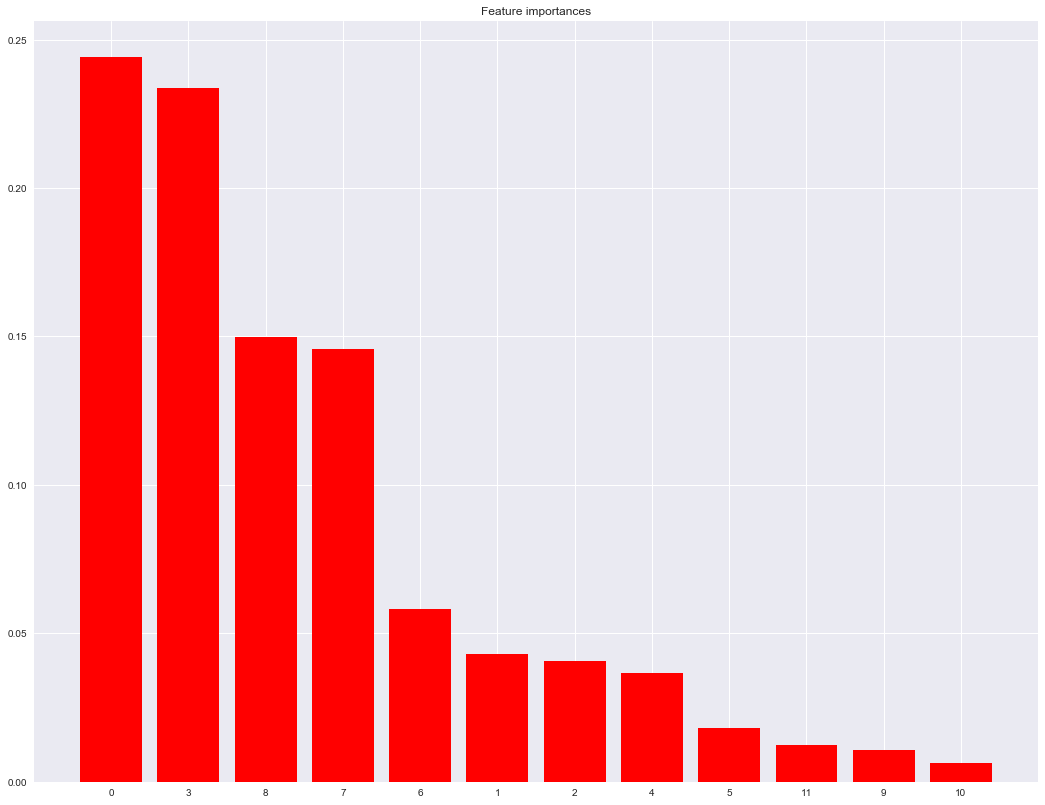

In [45]:
from sklearn.datasets import make_classification
from sklearn.ensemble import ExtraTreesClassifier

# Build a classification task using 3 informative features
#X, y = make_classification(n_samples=1000,
#                           n_features=10,
#                          n_informative=3,
#                           n_redundant=0,
#                           n_repeated=0,
#                           n_classes=2,
#                           random_state=0,
#                           shuffle=False)

# Build a forest and compute the feature importances
forest = ExtraTreesClassifier(n_estimators=250,
                              random_state=0)

forest.fit(X, y)
importances = forest.feature_importances_
std = np.std([tree.feature_importances_ for tree in forest.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

# Print the feature ranking
#print("Feature ranking:")

#for f in range(X.shape[1]):
#    print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))

# Plot the feature importances of the forest
plt.figure(figsize=(18,14))
plt.title("Feature importances")
#plt.bar(range(X.shape[1]), importances[indices],
#       color="r", yerr=std[indices], align="center")

plt.bar(range(X.shape[1]), importances[indices],
       color="r", align="center")

plt.xticks(range(X.shape[1]), indices)
plt.xlim([-1, X.shape[1]])
plt.show()

### Model Training
For the sake of early versions use all features for learning. Use 5 fold CV grid search (with 1 fold labelled test set and will not be the part of parameter tuning)

First split into 4:1 train/CV and test dataset

In [46]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

from sklearn import preprocessing
min_max_scaler = preprocessing.MinMaxScaler()
X_train[X_train.columns] = min_max_scaler.fit_transform(X_train[X_train.columns])
#Use only transform method to transform X_test based on X_train range
X_test[X_test.columns] = min_max_scaler.transform(X_test[X_test.columns])

In [47]:
#import xgboost as xgb
from sklearn import svm
from sklearn.grid_search import GridSearchCV

clf = svm.SVC()
# specify parameters via map
parameters = {'kernel':['linear', 'poly', 'rbf', 'sigmoid'],
              'degree':[2,3,4],
              'C': [(2**exp for exp in range(-7, 17))], 
              'gamma': [(2**exp for exp in range(-17, 7))]
             }
#xgb_model = xgb.XGBClassifier()
clf = GridSearchCV(clf, parameters, n_jobs=1, 
                   cv=4, 
                   scoring='roc_auc',
                   verbose=2, refit=False)
clf.fit(X_train,y_train)
best_param_4CV = clf.best_params_

Fitting 4 folds for each of 12 candidates, totalling 48 fits
[CV] kernel=linear, C=<generator object <genexpr> at 0x11e603fa0>, gamma=<generator object <genexpr> at 0x11e615050>, degree=2 


/Users/theerit/anaconda/envs/ipykernel_py2/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/Users/theerit/anaconda/envs/ipykernel_py2/lib/python2.7/site-packages/sklearn/grid_search.py:43: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


TypeError: a float is required

Performance on the 4thCV fold

In [116]:
print('Best AUC score:'+str(clf.best_score_))
print('Best Param:' +str(clf.best_params_))

Best AUC score:0.861301600108
Best Param:{'objective': 'binary:logistic', 'subsample': 0.6, 'learning_rate': 0.05, 'colsample_bytree': 0.6, 'max_depth': 7}


Now check performance on accuracy basis.

In [117]:
clf2 = svm.SVC(
        kernel = best_param_4CV['kernel'],
        degree = best_param_4CV['degree'],
        C =  best_param_4CV['C'],
        gamma = best_param_4CV['gamma'],
        )
clf2.fit(X_train,y_train)
from sklearn.metrics import accuracy_score
print('Accuracy:'+str(accuracy_score(y_train,clf2.predict(X_train))))

Accuracy:0.89606741573


In [118]:
import pickle
# save the model to disk
pickle.dump(clf2, open(filename, 'wb'))

Now check performance on the test set.

In [119]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
print('Test set AUC score:'+str(roc_auc_score(y_test,clf2.predict(X_test))))
print('Test set Accuracy:'+str(accuracy_score(y_test,clf2.predict(X_test))))

Test set AUC score:0.816473616474
Test set Accuracy:0.826815642458
